## Using Laplace Torch library to implement laplace approximation for bayesian linear regression

In [59]:
import torch
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import numpy as np
from laplace.baselaplace import FullLaplace, BaseLaplace
from laplace.curvature.backpack import BackPackGGN
from laplace import Laplace, marglik_training


In [60]:
def get_sinusoid_example(n_data=150, sigma_noise=0.3, batch_size=150):
    # create simple sinusoid data set
    X_train = (torch.rand(n_data) * 8).unsqueeze(-1)
    y_train = torch.sin(X_train) + torch.randn_like(X_train) * sigma_noise
    train_loader = data_utils.DataLoader(
        data_utils.TensorDataset(X_train, y_train), 
        batch_size=batch_size
    )
    X_test = torch.linspace(-5, 13, 500).unsqueeze(-1)
    return X_train, y_train, train_loader, X_test

In [61]:
def get_linear_example(n_data=150, sigma_noise=0.3, batch_size=150):
    # create simple linear data set
    X_train = (torch.rand(n_data) * 8).unsqueeze(-1)
    print(X_train)
    y_train = 3*X_train + 2 + torch.randn_like(X_train) * sigma_noise
    print(y_train)
    train_loader = data_utils.DataLoader(
        data_utils.TensorDataset(X_train, y_train), 
        batch_size=batch_size
    )
    X_test = torch.linspace(-5, 13, 500).unsqueeze(-1)
    return X_train, y_train, train_loader, X_test

tensor([[6.9840],
        [6.7393],
        [1.5205],
        [2.2821],
        [2.4346],
        [2.3965],
        [7.1137],
        [5.3591],
        [7.2054],
        [3.8129]])
tensor([[19.6069],
        [23.6832],
        [ 6.6773],
        [10.4168],
        [13.1039],
        [11.4536],
        [20.2560],
        [18.7943],
        [20.7698],
        [13.8648]])


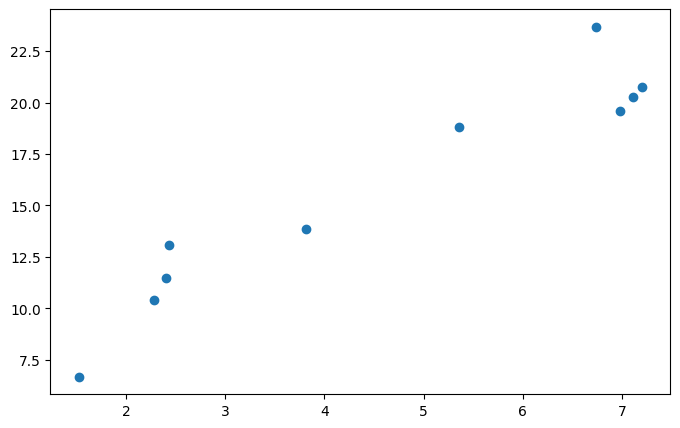

In [62]:
# Plot the data

X_train, y_train, train_loader, X_test = get_linear_example(n_data=10, sigma_noise=2, batch_size=10)

def plot_data(X_train, y_train, X_test=None, y_test=None, samples=None):
    plt.figure(figsize=(8, 5))
    plt.scatter(X_train.numpy(), y_train.numpy())
    if X_test is not None:
        plt.plot(X_test.numpy(), y_test.numpy(), color='k')
    if samples is not None:
        plt.plot(X_test.numpy(), samples.numpy(), color='r', alpha=0.2)
    plt.show()

plot_data(X_train, y_train)



In [63]:
for X,y in train_loader:
    print("X: ",X)
    print("y: ",y)

X:  tensor([[6.9840],
        [6.7393],
        [1.5205],
        [2.2821],
        [2.4346],
        [2.3965],
        [7.1137],
        [5.3591],
        [7.2054],
        [3.8129]])
y:  tensor([[19.6069],
        [23.6832],
        [ 6.6773],
        [10.4168],
        [13.1039],
        [11.4536],
        [20.2560],
        [18.7943],
        [20.7698],
        [13.8648]])


#### Prior

In [64]:
prior_mean_1 = -3
prior_std_1 = 1
prior_mean_0 = 2
prior_std_0 = 1

prior_dist_1 = torch.distributions.Normal(prior_mean_1, prior_std_1)
prior_dist_0 = torch.distributions.Normal(prior_mean_0, prior_std_0)

In [65]:
# define a simple linear regression model with the name LinearRegressionModel

class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(1, 1)
        
    def forward(self, x):
        return self.linear(x)
    
    def log_likelihood(self, x, y):
        y_pred = self.forward(x).squeeze(-1)
        return torch.distributions.Normal(y_pred, 0.3).log_prob(y).sum()
    
    def log_prior(self):
        return prior_dist_1.log_prob(self.linear.weight).sum() + prior_dist_0.log_prob(self.linear.bias).sum()
    
    def log_posterior(self, x, y):
        return self.log_likelihood(x, y) + self.log_prior()
    

In [66]:
model = LinearRegressionModel()
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.8971]], requires_grad=True)
Parameter containing:
tensor([-0.9640], requires_grad=True)


#### Theta MAP

In [67]:
n_epochs = 1000

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = -model.log_posterior(X,y)
        loss.backward()
        optimizer.step()


In [68]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[2.1733]], requires_grad=True)
Parameter containing:
tensor([3.8832], requires_grad=True)


In [69]:
print(type(train_loader))
train_loader

<class 'torch.utils.data.dataloader.DataLoader'>


In [70]:
print(type(train_loader))
train_loader

<class 'torch.utils.data.dataloader.DataLoader'>


In [75]:
la = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(train_loader)

In [13]:
# take prior as a standard normal distribution
# log_prior = torch.zeros(la.n_params, requires_grad=True)
# log_sigma = torch.tensor(0.5 * torch.ones(1, requires_grad=True), requires_grad=True)
log_prior, log_sigma = torch.ones(2, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [14]:
log_prior, log_sigma

(tensor([-0.8914, -3.2907], requires_grad=True),
 tensor([1.2553], requires_grad=True))

In [73]:
def plot_regression(X_train, y_train, X_test, f_test, y_std, plot=True, 
                    file_name='regression_example'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True,
                                figsize=(8, 4))
    ax1.set_title('MAP')
    ax1.scatter(X_train.flatten(), y_train.flatten(), alpha=0.3, color='tab:orange')
    ax1.plot(X_test, f_test, color='black', label='$f_{MAP}$')
    ax1.legend()

    ax2.set_title('LA')
    ax2.scatter(X_train.flatten(), y_train.flatten(), alpha=0.3, color='tab:orange')
    ax2.plot(X_test, f_test, label='$\mathbb{E}[f]$')
    ax2.fill_between(X_test, f_test-y_std*2, f_test+y_std*2, 
                     alpha=0.3, color='tab:blue', label='$2\sqrt{\mathbb{V}\,[y]}$')
    ax2.legend()
    # ax1.set_ylim([0, 30])
    ax1.set_xlim([X_test.min(), X_test.max()])
    ax2.set_xlim([X_test.min(), X_test.max()])
    ax1.set_ylabel('$y$')
    ax1.set_xlabel('$x$')
    ax2.set_xlabel('$x$')
    plt.tight_layout()
    if plot:
        plt.show()

#### Laplace Approximation for Posterior

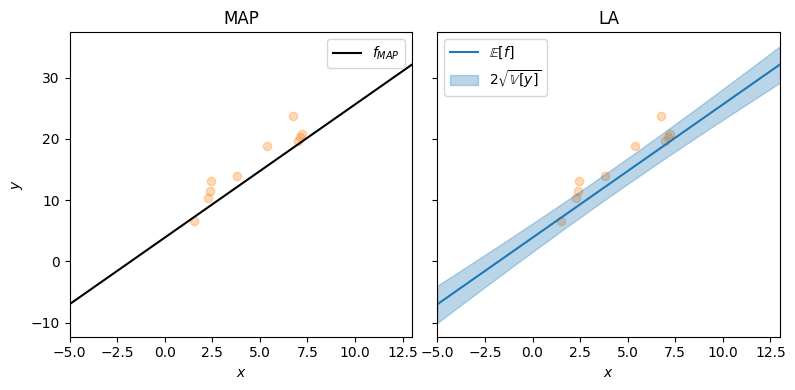

In [74]:
x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std)

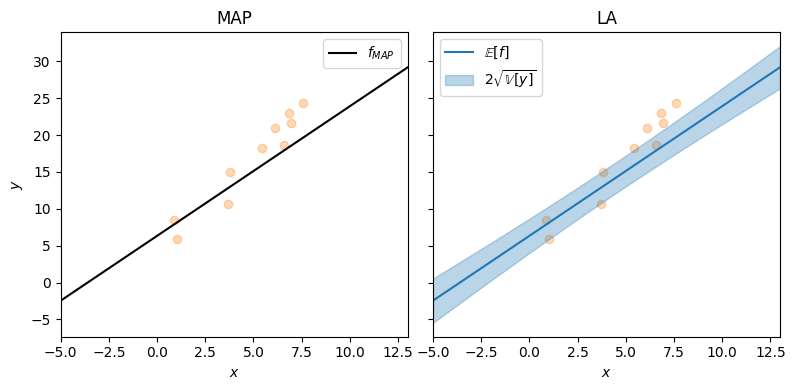

In [44]:
x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std)

#### Laplace Approximation for Likelihood

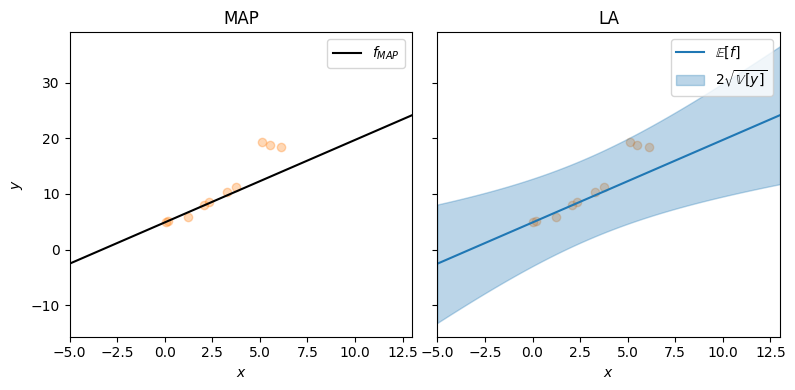

In [18]:
x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std)

## Using BaseLaplace -> not implemented only

## Using FullLaplace -> don't know what is the difference

# Dataset with heteroskadastic noise

In [45]:
def get_heteroscedastic_example(n_data=150,batch_size=150):
    torch.manual_seed(42)
    x_lin = torch.linspace(-1, 1, n_data)
    x_train = x_lin.unsqueeze(-1)
    f = lambda x: 0.5 * x**2 + 0.25 * x**3
    eps = torch.randn(n_data) * (0.1 + 0.4 * x_lin)
    y = f(x_lin) + eps
    y_train = y.unsqueeze(-1)
    train_loader_hetero = data_utils.DataLoader(
        data_utils.TensorDataset(x_train, y_train), 
        batch_size=batch_size
    )
    x_test = torch.linspace(-1, 1, 500).unsqueeze(-1)
    return x_train, y_train, train_loader_hetero, x_test

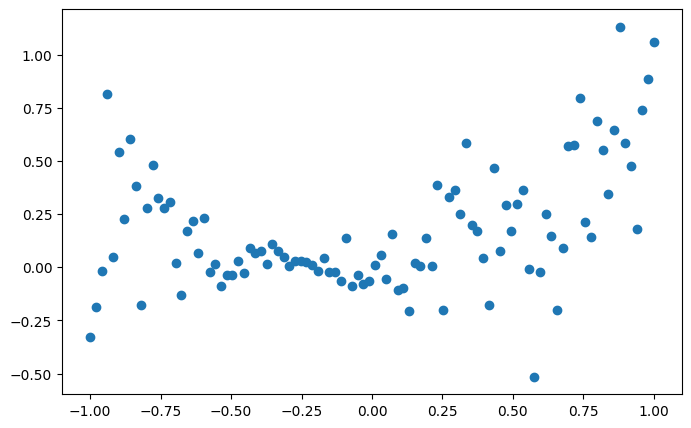

In [46]:
x_train, y_train, train_loader_hetero, x_test = get_heteroscedastic_example(n_data=100, batch_size=100)

plot_data(x_train, y_train)

In [47]:
class HeteroskedasticNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(1, 2)

    def forward(self, x):
        z = self.linear(x)
        mu_hat = z[:, 0]
        log_noise_std = z[:, 1]
        return mu_hat, log_noise_std
    
    def log_likelihood(self, x, y):
        mu_hat, log_noise_std = self.forward(x)
        return torch.distributions.Normal(mu_hat, log_noise_std.exp()).log_prob(y).sum()
    
    def log_prior(self):
        return prior_dist_1.log_prob(self.linear.weight).sum() + prior_dist_0.log_prob(self.linear.bias).sum()
    
    def log_posterior(self, x, y):
        return self.log_likelihood(x, y) + self.log_prior()

In [48]:
model = HeteroskedasticNN()
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.1564],
        [-0.8799]], requires_grad=True)
Parameter containing:
tensor([-0.4309, -0.5987], requires_grad=True)


In [49]:
n_epochs = 1000

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader_hetero:
        optimizer.zero_grad()
        loss = -model.log_posterior(X,y)
        loss.backward()
        optimizer.step()


In [50]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-7.5651e-05],
        [-4.4117e-04]], requires_grad=True)
Parameter containing:
tensor([ 0.1720, -1.2282], requires_grad=True)


In [52]:
type(train_loader_hetero)
train_loader_hetero

In [53]:
type(train_loader)
train_loader

In [54]:
la_hetero = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
la_hetero.fit(train_loader_hetero)

AttributeError: 'tuple' object has no attribute 'shape'